# Point operations
In this notebook we show some homogeneneous point operations. They depends only on one pixel and not on any other neighbor pixel.

In [1]:
import numpy as np
import skimage
from skimage import io
from skimage import util
import matplotlib.pyplot as plt

## Contrast and brightness

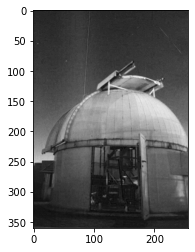

In [2]:
lidar = io.imread('images/lidar.png')[:,:,0] # use only one channel
rows, cols = lidar.shape 
plt.imshow(lidar, cmap='gray')

In [3]:
def dip_setContrastBrightness(image, contrast, brightness):
    rows, cols = image.shape
    image_cb = np.zeros((rows, cols), dtype=int)
    for col in np.arange(0, cols, 1):
        for row in np.arange(0, rows, 1):
            v = image[row, col]
            vcb = contrast * v + brightness
            if vcb > 255: vcb = 255
            image_cb[row, col] = vcb
    return image_cb        

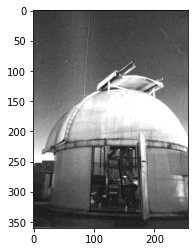

In [4]:
lidar_cb = dip_setContrastBrightness(lidar, 1.5, 10)
plt.imshow(lidar_cb, cmap='gray')

## Image inversion

In [5]:
def dip_invert(image):
    rows, cols = image.shape
    inverted_image = np.zeros((rows, cols), dtype=int)
    for col in np.arange(0, cols, 1):
        for row in np.arange(0, rows, 1):
            v = image[row, col]
            inverted_image[row, col] = 255 - v
    return inverted_image

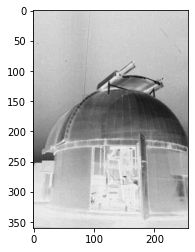

In [6]:
lidar_inv = dip_invert(lidar)
plt.imshow(lidar_inv, cmap='gray')

We show how the inversion operation affects the histogram of the image

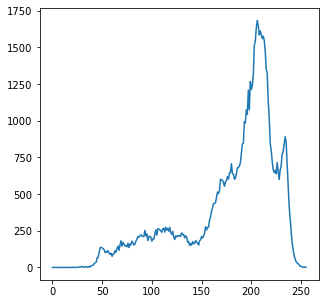

In [8]:
from ipynb.fs.full.histograms import dip_histogram
inverse_histogram = dip_histogram(lidar_inv)
x =np.arange(0, 256, 1)
fig = plt.figure(figsize=(5, 5))
ax = fig.add_subplot()
plt.plot(x, inverse_histogram)

The same result can be obtained using the scikit-image function for [image inversion](https://scikit-image.org/docs/dev/user_guide/transforming_image_data.html?highlight=inversion#image-inversion)

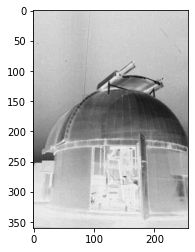

In [9]:
inverted_lidar = util.invert(lidar)
plt.imshow(inverted_lidar, cmap='gray')

## Thresholding
Thresholding is used to create a binary image from a grayscale image.

In [10]:
def dip_threshold(image):
    threshold = 128
    rows, cols = image.shape
    threshold_image = np.zeros((rows, cols), dtype=int)
    for col in np.arange(0, cols, 1):
        for row in np.arange(0, rows, 1):
            v = image[row, col]
            if v > threshold:
                threshold_image[row, col] = 200
            else:
                threshold_image[row, col] = 50
    return threshold_image

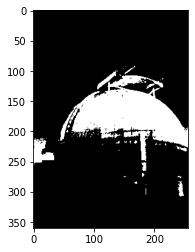

In [11]:
lidar_thr = dip_threshold(lidar)
plt.imshow(lidar_thr, cmap='gray')

After the thresholding the histogram of the image has only two entries

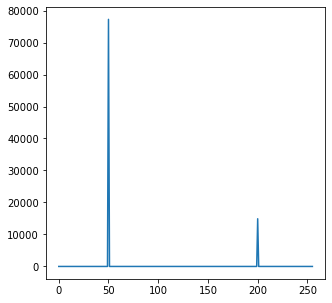

In [12]:
hist_threshold = dip_histogram(lidar_thr)
x =np.arange(0, 256, 1)
fig = plt.figure(figsize=(5, 5))
ax = fig.add_subplot()
plt.plot(x, hist_threshold)

scikit-image provides more sophisticated [thresholding functions](https://scikit-image.org/docs/dev/auto_examples/applications/plot_thresholding.html)

## Histogram equalization
The purpose of the equalizatione is to have a more uniform distribution of the pixel values.

In [13]:
img = skimage.data.moon()
from ipynb.fs.full.histograms import dip_cumulativeHistogram
img_histogram = dip_histogram(img)
img_cumulative_hist = dip_cumulativeHistogram(img_histogram)

In [14]:
def dip_histogramEqualization(image, cumulative_histogram):
    rows, cols = image.shape
    equalized_image = np.zeros((rows, cols), dtype=int)
    for col in np.arange(0, cols, 1):
        for row in np.arange(0, rows, 1):
            v = image[row, col]
            equalized_image[row, col] = cumulative_histogram[v] * 255 / (rows * cols)
    return equalized_image

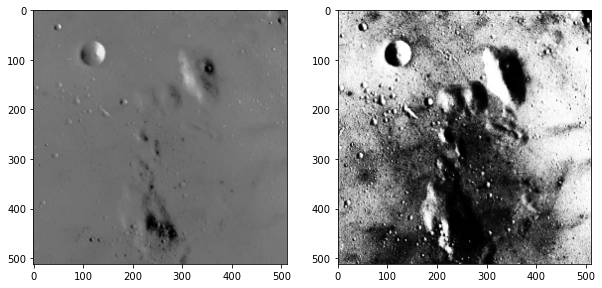

In [15]:
img_equalized = dip_histogramEqualization(img, img_cumulative_hist)
fig = plt.figure(figsize=(10, 5))
fig.add_subplot(1, 2, 1)
plt.imshow(img, cmap='gray')
fig.add_subplot(1, 2, 2)
plt.imshow(img_equalized, cmap='gray')
plt.show()

The cumulative histogram of the equalized image should be linear

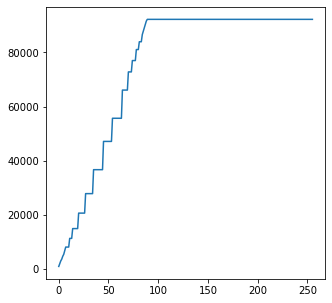

In [16]:
img_eq_histogram = dip_histogram(img_equalized)
img_eq_cumulative_histogram = dip_cumulativeHistogram(img_eq_histogram)
x =np.arange(0, 256, 1)
fig = plt.figure(figsize=(5, 5))
ax = fig.add_subplot()
plt.plot(x, img_eq_cumulative_histogram)

scikit-image provides two functions for [histogram equalization](https://scikit-image.org/docs/dev/auto_examples/color_exposure/plot_equalize.html)